In [1]:
!pip install pydot

In [38]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras import Model
import tensorflow_addons as tfa
import tensorflow as tf
from IPython import display

### Dataset

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
#   "/home/tony/TO_BE_REMOVED/celeba_data/imgs/",
  "/Users/anthonylaw/Desktop/Endless/GAN-devel/datasets/afhq/train",
  seed=123,
  image_size=(256, 256),
  batch_size=2)

Found 14630 files belonging to 3 classes.


2022-09-21 11:26:42.567343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
K=len(train_ds.class_names)
print(K)

3


In [6]:
for im, l in train_ds.take(1):
    imgs = im
#     print(imgs.shape)
    print(l)

tf.Tensor([1 1], shape=(2,), dtype=int32)


### Img to Img Generator with style code injection

#### Note:

Implemented with Pre-Act ResBlk

#### Staged model

In [3]:
# ResBLKs require a couple of hyperparams: (filters, kernel size, downsample/upsample scale(strides)) 
# each down sample blk will have a mirroring upsample blk, strides are passed in a forward fashion
# NOTE: 1. when staging, design kernel size/stride carefully
#       2. by design, please make sure models are built before called in tf.graphs to prevent retracing, build graph function is provided for such purpose

class Generator(Model):
    
    def __init__(self, image_shape_in, num_channel,
                 stage_filters=(16, 32, 64), stage_kernels=(3, 3, 3),
                 stage_strides_ds=(2,2,0), stage_strides_us=(2,2,0)):
        super().__init__()
        
        # staging params must be equal
        assert len(stage_filters) == len(stage_kernels)
        assert len(stage_filters) == len(stage_strides_ds)
        assert len(stage_filters) == len(stage_strides_us)
        
        self.image_shape_in = image_shape_in
        self.num_channel = num_channel
        
        # ResBLK layers, downsample blk layers separated from upsample blk layers
        self.ins1 = []
        self.relus1_ds = []
        self.convs1_ds = []
        
        self.ins2 = []
        self.relus2_ds = []
        self.convs2_ds = []
        
        self.adds_ds = []
        self.dss = []

        self.adains1 = []
        self.relus1_us = []
        self.convs1_us = []
        
        self.adains2 = []
        self.relus2_us = []
        self.convs2_us = []

        self.adds_us = []
        self.uss = []
        
        for idx in range(len(stage_filters)):
            self.adds_ds.append(layers.Add())
            self.adds_us.append(layers.Add())
            self.ins1.append(tfa.layers.InstanceNormalization(axis=-1))
            self.ins2.append(tfa.layers.InstanceNormalization(axis=-1))
            self.adains1.append(tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False))
            self.adains2.append(tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False))
            self.relus1_ds.append(layers.ReLU())
            self.relus2_ds.append(layers.ReLU())
            self.relus1_us.append(layers.ReLU())
            self.relus2_us.append(layers.ReLU())
            self.convs1_ds.append(layers.Conv2D(stage_filters[idx],(stage_kernels[idx],stage_kernels[idx]),
                                               strides=(1, 1), padding='same'))
            self.convs2_ds.append(layers.Conv2D(stage_filters[idx],(stage_kernels[idx],stage_kernels[idx]),
                                               strides=(1, 1), padding='same'))
            self.convs1_us.append(layers.Conv2D(stage_filters[idx],(stage_kernels[idx],stage_kernels[idx]),
                                               strides=(1, 1), padding='same'))
            self.convs2_us.append(layers.Conv2D(stage_filters[idx],(stage_kernels[idx],stage_kernels[idx]),
                                               strides=(1, 1), padding='same'))
            
            if stage_strides_ds[idx] == 0:
                self.dss.append(0)

            else:
                self.dss.append(layers.Conv2D(stage_filters[idx+1], (stage_kernels[idx],stage_kernels[idx]),
                                               strides=(stage_strides_ds[idx],stage_strides_ds[idx]), padding='same'))

            if stage_strides_us[idx] == 0:
                self.uss.append(0)
                
            else:
                self.uss.append(layers.Conv2DTranspose(stage_filters[-2-idx], (stage_kernels[idx],stage_kernels[idx]),
                                               strides=(stage_strides_us[idx],stage_strides_us[idx]), padding='same'))
        self.convs1_us.reverse()
        self.convs2_us.reverse()
        
        # in conv 1x1
        self.in_conv11 = layers.Conv2D(stage_filters[0], (1, 1),
                                        strides=(1, 1), padding='same',
                                        input_shape=(None, self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        # out conv 1x1
        self.out_conv11 = layers.Conv2D(self.num_channel, (1, 1),
                                        strides=(1, 1), padding='same', activation="tanh")
            
    def call(self, img_in, s_c):
        if img_in.shape[0] == None:
            mu_sc = tf.reshape(tf.reduce_mean(s_c, axis=-1), (1,1,1,1))
            sigma_sc = tf.reshape(tf.math.reduce_std(s_c, axis=-1), (1,1,1,1))
        else:
            mu_sc = tf.reshape(tf.reduce_mean(s_c, axis=-1), (img_in.shape[0],1,1,1))
            sigma_sc = tf.reshape(tf.math.reduce_std(s_c, axis=-1), (img_in.shape[0],1,1,1))      
            
        # conv 1x1
        x = self.in_conv11(img_in)
        
        # downsample blks
        for idx in range(len(self.adds_ds)):
            x_res = self.convs1_ds[idx](self.relus1_ds[idx](self.ins1[idx](x)))
            x_res = self.convs2_ds[idx](self.relus2_ds[idx](self.ins2[idx](x_res)))
            x = self.adds_ds[idx]([x, x_res])
            if not self.dss[idx]==0:
                x = self.dss[idx](x)
                
        # upsample blks
        for idx in range(len(self.adds_us)):
            x_res = self.convs1_us[idx](self.relus1_us[idx](tf.math.add(tf.math.multiply(self.adains1[idx](x), sigma_sc), mu_sc)))
            x_res = self.convs2_us[idx](self.relus2_us[idx](tf.math.add(tf.math.multiply(self.adains2[idx](x_res), sigma_sc), mu_sc)))
            x = self.adds_us[idx]([x, x_res])
            if not self.uss[idx]==0:
                x = self.uss[idx](x)
        
        x = self.out_conv11(x)
        
        return x
    
    def build_graph(self, sc_dims):
        x = layers.Input(shape=(self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        sc = tf.random.normal((sc_dims,))
        return Model(inputs=x, outputs=self.call(x,sc))
        

#### Testing

In [129]:
a=[1,2,3,4,5]
a.reverse()

In [130]:
print(a)

[5, 4, 3, 2, 1]


In [12]:
g_t = Generator((256,256),3)

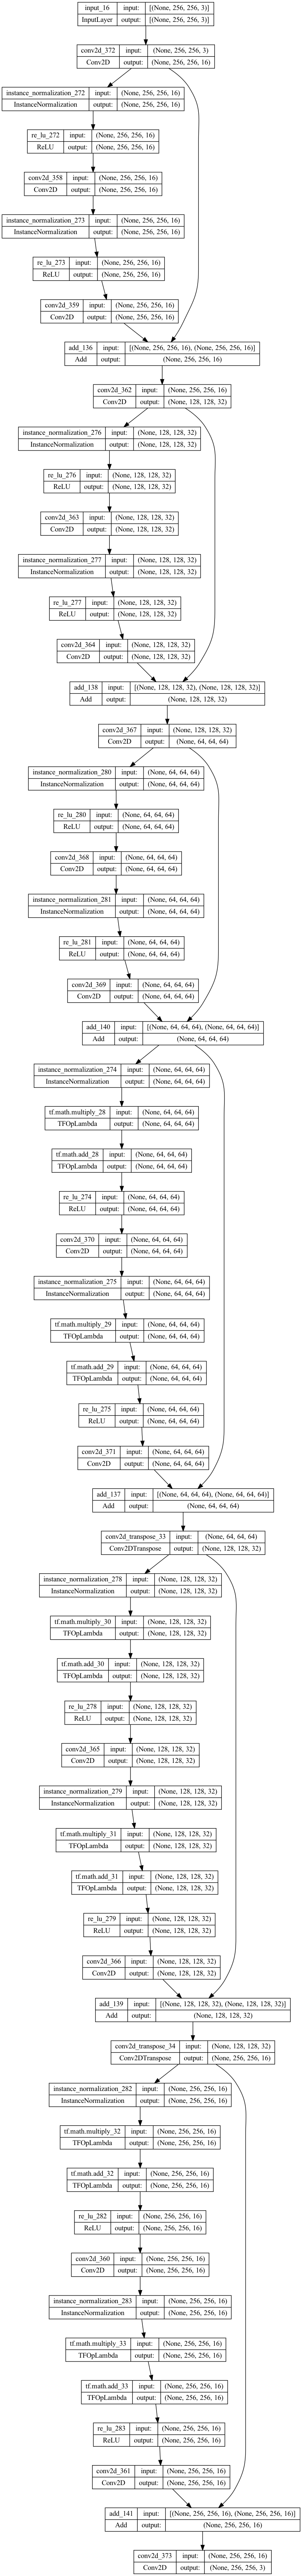

In [132]:
tf.keras.utils.plot_model(g_t.build_graph(64), show_shapes=True)

#### Fixed Model

In [38]:
class Generator(Model):
    
    def __init__(self, image_shape_in, num_channel, kernel_size=3):
        super().__init__()
        
        self.image_shape_in = image_shape_in
        self.num_channel = num_channel
        self.kernel_size = kernel_size
        
        # add layer(multiple for plot clarification)
        self.add1 = layers.Add()
        self.add2 = layers.Add()
        self.add3 = layers.Add()
        self.add4 = layers.Add()
        self.add5 = layers.Add()
        self.add6 = layers.Add()
        
        # in conv 1x1
        self.in_conv11 = layers.Conv2D(16, (1, 1),
                                        strides=(1, 1), padding='same',
                                        input_shape=(None, self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        # resblk 1 IN
        self.rb1_in1 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb1_rl1 = layers.ReLU()
        self.rb1_conv2d1 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb1_in2 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb1_rl2 = layers.ReLU()
        self.rb1_conv2d2 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 1
        self.ds1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')

        # resblk 2 IN
        self.rb2_in1 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb2_rl1 = layers.ReLU()
        self.rb2_conv2d1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb2_in2 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb2_rl2 = layers.ReLU()
        self.rb2_conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 2
        self.ds2 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        
        # resblk 3 IN
        self.rb3_in1 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb3_rl1 = layers.ReLU()
        self.rb3_conv2d1 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb3_in2 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb3_rl2 = layers.ReLU()
        self.rb3_conv2d2 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # resblk 4 AdaIN
        self.rb4_in1 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb4_rl1 = layers.ReLU()
        self.rb4_conv2d1 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb4_in2 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb4_rl2 = layers.ReLU()
        self.rb4_conv2d2 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # upsample 1
        self.us1 = layers.Conv2DTranspose(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        # resblk 5 AdaIN
        self.rb5_in1 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb5_rl1 = layers.ReLU()
        self.rb5_conv2d1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb5_in2 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb5_rl2 = layers.ReLU()
        self.rb5_conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # upsample 2
        self.us2 = layers.Conv2DTranspose(16, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # resblk 6 AdaIN
        self.rb6_in1 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb6_rl1 = layers.ReLU()
        self.rb6_conv2d1 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb6_in2 = tfa.layers.InstanceNormalization(axis=-1,center=False,scale=False)
        self.rb6_rl2 = layers.ReLU()
        self.rb6_conv2d2 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # out conv 1x1
        self.out_conv11 = layers.Conv2D(self.num_channel, (1, 1),
                                        strides=(1, 1), padding='same', activation="tanh")
            
    def call(self, img_in, s_c):
        if img_in.shape[0] == None:
            mu_sc = tf.reshape(tf.reduce_mean(s_c, axis=-1), (1,1,1,1))
            sigma_sc = tf.reshape(tf.math.reduce_std(s_c, axis=-1), (1,1,1,1))
        else:
            mu_sc = tf.reshape(tf.reduce_mean(s_c, axis=-1), (img_in.shape[0],1,1,1))
            sigma_sc = tf.reshape(tf.math.reduce_std(s_c, axis=-1), (img_in.shape[0],1,1,1))        
        # conv 1x1
        x = self.in_conv11(img_in)
        
        # resblk 1
        x_res = self.rb1_conv2d1(self.rb1_rl1(self.rb1_in1(x)))
        x_res = self.rb1_conv2d2(self.rb1_rl2(self.rb1_in2(x_res)))
        x = self.add1([x, x_res])
        
        # resblk 1 downsample
        x = self.ds1(x)
        
        # resblk 2
        x_res = self.rb2_conv2d1(self.rb2_rl1(self.rb2_in1(x)))
        x_res = self.rb2_conv2d2(self.rb2_rl2(self.rb2_in2(x_res)))
        x = self.add2([x, x_res])
        
        # resblk 2 downsample
        x = self.ds2(x)
        
        # resblk 3
        x_res = self.rb3_conv2d1(self.rb3_rl1(self.rb3_in1(x)))
        x_res = self.rb3_conv2d2(self.rb3_rl2(self.rb3_in2(x_res)))
        x = self.add3([x, x_res])
        
        # resblk 4 AdaIN
        x_res = self.rb4_conv2d1(self.rb4_rl1(tf.math.add(tf.math.multiply(self.rb4_in1(x), sigma_sc), mu_sc)))
        x_res = self.rb4_conv2d2(self.rb4_rl2(tf.math.add(tf.math.multiply(self.rb4_in2(x_res), sigma_sc), mu_sc)))
        x = self.add4([x, x_res])

        # resblk 5 upsample
        x = self.us1(x)

        # resblk 5 AdaIN
        x_res = self.rb5_conv2d1(self.rb5_rl1(tf.math.add(tf.math.multiply(self.rb5_in1(x), sigma_sc), mu_sc)))
        x_res = self.rb5_conv2d2(self.rb5_rl2(tf.math.add(tf.math.multiply(self.rb5_in2(x_res), sigma_sc), mu_sc)))
        x = self.add5([x, x_res])

        # resblk 6 upsample
        x = self.us2(x)
        
        # resblk 6 AdaIN
        x_res = self.rb6_conv2d1(self.rb6_rl1(tf.math.add(tf.math.multiply(self.rb6_in1(x), sigma_sc), mu_sc)))
        x_res = self.rb6_conv2d2(self.rb6_rl2(tf.math.add(tf.math.multiply(self.rb6_in2(x_res), sigma_sc), mu_sc)))
        x = self.add6([x, x_res])

        # conv 1x1 out
        x = self.out_conv11(x)
        
        return x
    
    def build_graph(self):
        x = layers.Input(shape=(self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        sc = tf.random.normal((64,))
        return Model(inputs=x, outputs=self.call(x,sc))
        

#### Testing

In [39]:
g_t = Generator((256,256),3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


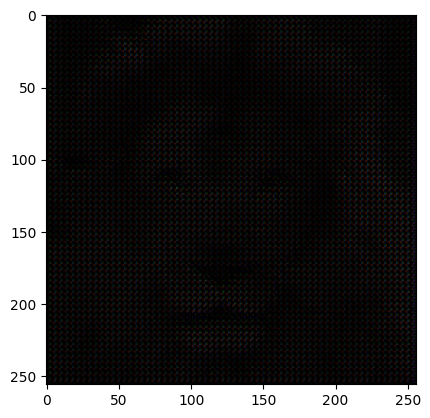

In [40]:
for img, l in train_ds.take(1):
    img = g_t(img, tf.random.normal((2,16)))
    plt.imshow(tf.cast(tf.math.round(img[1]), dtype=tf.int32))

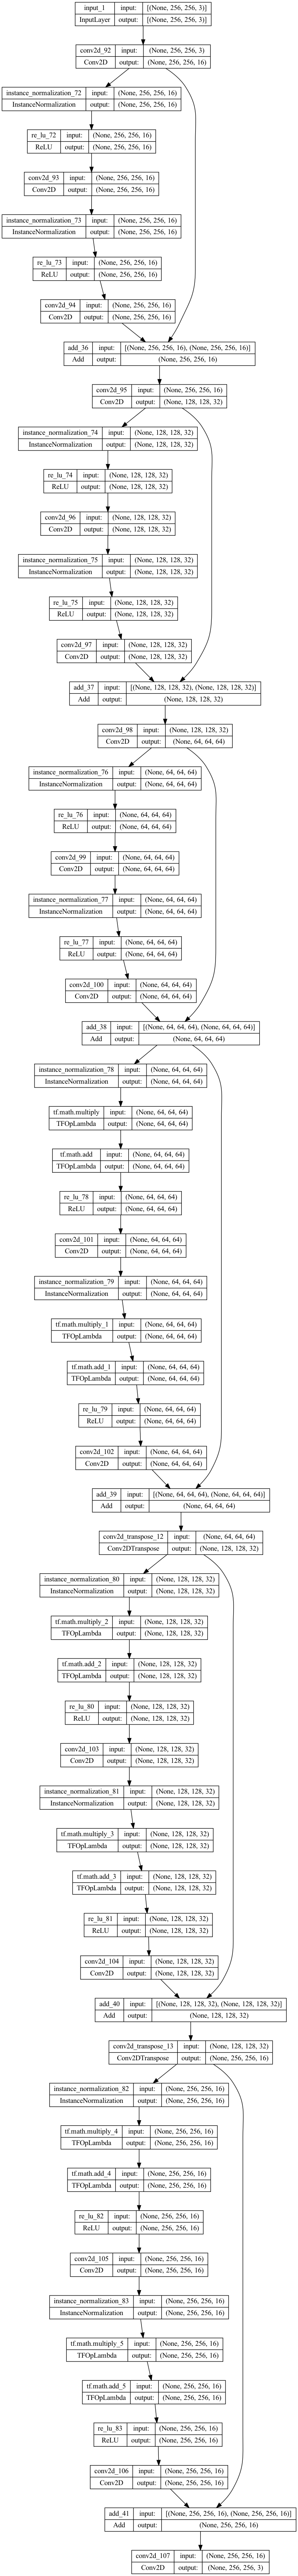

In [41]:
tf.keras.utils.plot_model(g_t.build_graph(), show_shapes=True)

In [168]:
g_t.build_graph(64).summary()

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_372 (Conv2D)            (None, 256, 256, 16  64          ['input_22[0][0]']               
                                )                                                                 
                                                                                                  
 instance_normalization_272 (In  (None, 256, 256, 16  32         ['conv2d_372[1][0]']             
 stanceNormalization)           )                                                          

 re_lu_274 (ReLU)               (None, 64, 64, 64)   0           ['tf.math.add_34[0][0]']         
                                                                                                  
 conv2d_370 (Conv2D)            (None, 64, 64, 64)   36928       ['re_lu_274[1][0]']              
                                                                                                  
 instance_normalization_275 (In  (None, 64, 64, 64)  0           ['conv2d_370[1][0]']             
 stanceNormalization)                                                                             
                                                                                                  
 tf.math.multiply_35 (TFOpLambd  (None, 64, 64, 64)  0           ['instance_normalization_275[1][0
 a)                                                              ]']                              
                                                                                                  
 tf.math.a

                                )                                                                 
                                                                                                  
 conv2d_361 (Conv2D)            (None, 256, 256, 16  2320        ['re_lu_283[1][0]']              
                                )                                                                 
                                                                                                  
 add_141 (Add)                  (None, 256, 256, 16  0           ['conv2d_transpose_34[1][0]',    
                                )                                 'conv2d_361[1][0]']             
                                                                                                  
 conv2d_373 (Conv2D)            (None, 256, 256, 3)  51          ['add_141[1][0]']                
                                                                                                  
Total para

### Mapping Network

In [4]:
class Mapper(Model):

    def __init__(self, noise_dim, sc_dims, num_domains):
        super().__init__()
        self.noise_dim = noise_dim
        self.sl1 = layers.Dense(256, activation="relu")
        self.sl2 = layers.Dense(256, activation="relu")
        self.domain_layers = []
        for i in range(num_domains):
            self.domain_layers.append([layers.Dense(256, activation="relu"), 
                                       layers.Dense(sc_dims)])

    def call(self, latent_code):

        x = self.sl1(latent_code)

        x = self.sl2(x)

        xs = []
        for dl in self.domain_layers:
            xs.append(dl[1](dl[0](x)))
        
        return tf.transpose(tf.convert_to_tensor(xs), [1,0,2])

    def build_graph(self):
        x = layers.Input(shape=(self.noise_dim,))
        return Model(inputs=x, outputs=self.call(x))
        

#### Testing

In [32]:
noise = tf.random.normal((2,1))

In [13]:
mapper1 = Mapper(1, 4, 3)

In [34]:
sc_1 = mapper1(noise)
print(sc_1)

tf.Tensor(
[[[ 0.00260167  0.00665396  0.01817647 -0.02189103]
  [-0.00013299  0.01139925  0.00109764  0.0181948 ]
  [-0.03215064  0.01423921  0.01101407 -0.01495722]]

 [[-0.0152117  -0.01004129  0.0063343  -0.0061995 ]
  [-0.00493224  0.00199769 -0.01778073  0.00998745]
  [-0.02325854 -0.01187972  0.0137092  -0.01620315]]], shape=(2, 3, 4), dtype=float32)


In [62]:
ls=[[0,2], [1,1]]
s1=[]
i=0
print(sc_1)
# print(tf.gather_nd(sc_1, tf.constant([[2],[1]])))
sam = sc_1
# for i in range(len(sam)):
#     s1 = tf.gather(sam,tf.constant(ls)[i])
#     print(s1)
# print(tf.gather_nd(sam, tf.constant(ls)))

idx = tf.constant([2,1])
nd_idx = tf.constant([[i, idx[i].numpy()] for i in range(2)])
print(nd_idx)
print(tf.gather_nd(sam, nd_idx))

tf.Tensor(
[[[ 0.00260167  0.00665396  0.01817647 -0.02189103]
  [-0.00013299  0.01139925  0.00109764  0.0181948 ]
  [-0.03215064  0.01423921  0.01101407 -0.01495722]]

 [[-0.0152117  -0.01004129  0.0063343  -0.0061995 ]
  [-0.00493224  0.00199769 -0.01778073  0.00998745]
  [-0.02325854 -0.01187972  0.0137092  -0.01620315]]], shape=(2, 3, 4), dtype=float32)
tf.Tensor(
[[0 2]
 [1 1]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[-0.03215064  0.01423921  0.01101407 -0.01495722]
 [-0.00493224  0.00199769 -0.01778073  0.00998745]], shape=(2, 4), dtype=float32)


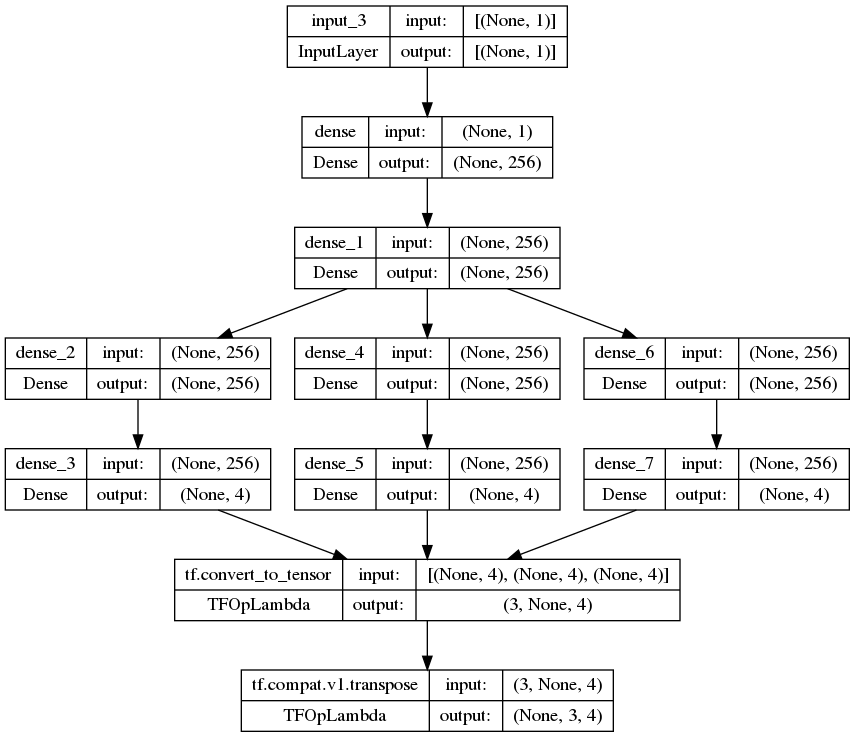

In [16]:
tf.keras.utils.plot_model(mapper1.build_graph(), show_shapes=True)

In [17]:
mapper1.build_graph().summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          512         ['input_4[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 256)          65792       ['dense[1][0]']                  
                                                                                                  
 dense_2 (Dense)                (None, 256)          65792       ['dense_1[1][0]']                
                                                                                            

### Style Encoder

#### Staged model

In [5]:
# ResBLKs require a couple of hyperparams: (filters, kernel size, downsample/upsample scale(strides)) 
# NOTE: 1. when staging, design kernel size/stride carefully
#       2. by design, please make sure models are built before called in tf.graphs to prevent retracing, build graph function is provided for such purpose

class StyleEncoder(Model):
    
    def __init__(self, image_shape_in, num_channel, sc_dims,  num_domains,
                 stage_filters=(16, 32, 64), stage_kernels=(3, 3, 3),
                 stage_strides_ds=(2,2,0)):
        super().__init__()
        
        # staging params must be equal
        assert len(stage_filters) == len(stage_kernels)
        assert len(stage_filters) == len(stage_strides_ds)
        
        self.image_shape_in = image_shape_in
        self.num_channel = num_channel
        
        # ResBLK layers, downsample blk layers separated from upsample blk layers

        self.relus1_ds = []
        self.convs1_ds = []
        
        self.relus2_ds = []
        self.convs2_ds = []
        
        self.adds_ds = []
        self.dss = []

        for idx in range(len(stage_filters)):
            self.adds_ds.append(layers.Add())

            self.relus1_ds.append(layers.LeakyReLU())
            self.relus2_ds.append(layers.LeakyReLU())

            self.convs1_ds.append(layers.Conv2D(stage_filters[idx],(stage_kernels[idx],stage_kernels[idx]),
                                               strides=(1, 1), padding='same'))
            self.convs2_ds.append(layers.Conv2D(stage_filters[idx],(stage_kernels[idx],stage_kernels[idx]),
                                               strides=(1, 1), padding='same'))

            if stage_strides_ds[idx] == 0:
                self.dss.append(0)

            else:
                self.dss.append(layers.Conv2D(stage_filters[idx+1], (stage_kernels[idx],stage_kernels[idx]),
                                               strides=(stage_strides_ds[idx],stage_strides_ds[idx]), padding='same'))

        
        # in conv 1x1
        self.in_conv11 = layers.Conv2D(stage_filters[0], (1, 1),
                                        strides=(1, 1), padding='same',
                                        input_shape=(None, self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        # final downsample
        self.fd_rl1 = layers.LeakyReLU()
        self.fd_ds = layers.Conv2D(stage_filters[-1], (stage_kernels[-1],stage_kernels[-1]),
                                               strides=(2, 2), padding='same')
        self.fd_rl2 = layers.LeakyReLU()
        
        # reshape for linear act
        self.rs_out = layers.Reshape((int(self.image_shape_in[0]/(2**(len(stage_strides_ds))))*int(self.image_shape_in[1]/(2**(len(stage_strides_ds))))*stage_filters[-1],))
        
        # style code production
        self.sc_layers = []
        for i in range(num_domains):
            self.sc_layers.append(layers.Dense(sc_dims))
            
            
    def call(self, img_in):
            
        # conv 1x1
        x = self.in_conv11(img_in)
        
        # downsample blks
        for idx in range(len(self.adds_ds)):
            x_res = self.convs1_ds[idx](self.relus1_ds[idx](x))
            x_res = self.convs2_ds[idx](self.relus2_ds[idx](x_res))
            x = self.adds_ds[idx]([x, x_res])
            if not self.dss[idx]==0:
                x = self.dss[idx](x)
                

        # final downsample
        x = self.fd_rl2(self.fd_ds(self.fd_rl1(x)))
        
        # reshape for linear act
        x = self.rs_out(x)
        
        # style code production
        scs = []
        for sc in self.sc_layers:
            scs.append(sc(x))
            
        return tf.transpose(tf.convert_to_tensor(scs), [1,0,2])
    
    def build_graph(self):
        x = layers.Input(shape=(self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        return Model(inputs=x, outputs=self.call(x))
        
        

#### Testing

In [14]:
se1 = StyleEncoder((256,256), 3, 4, 3)

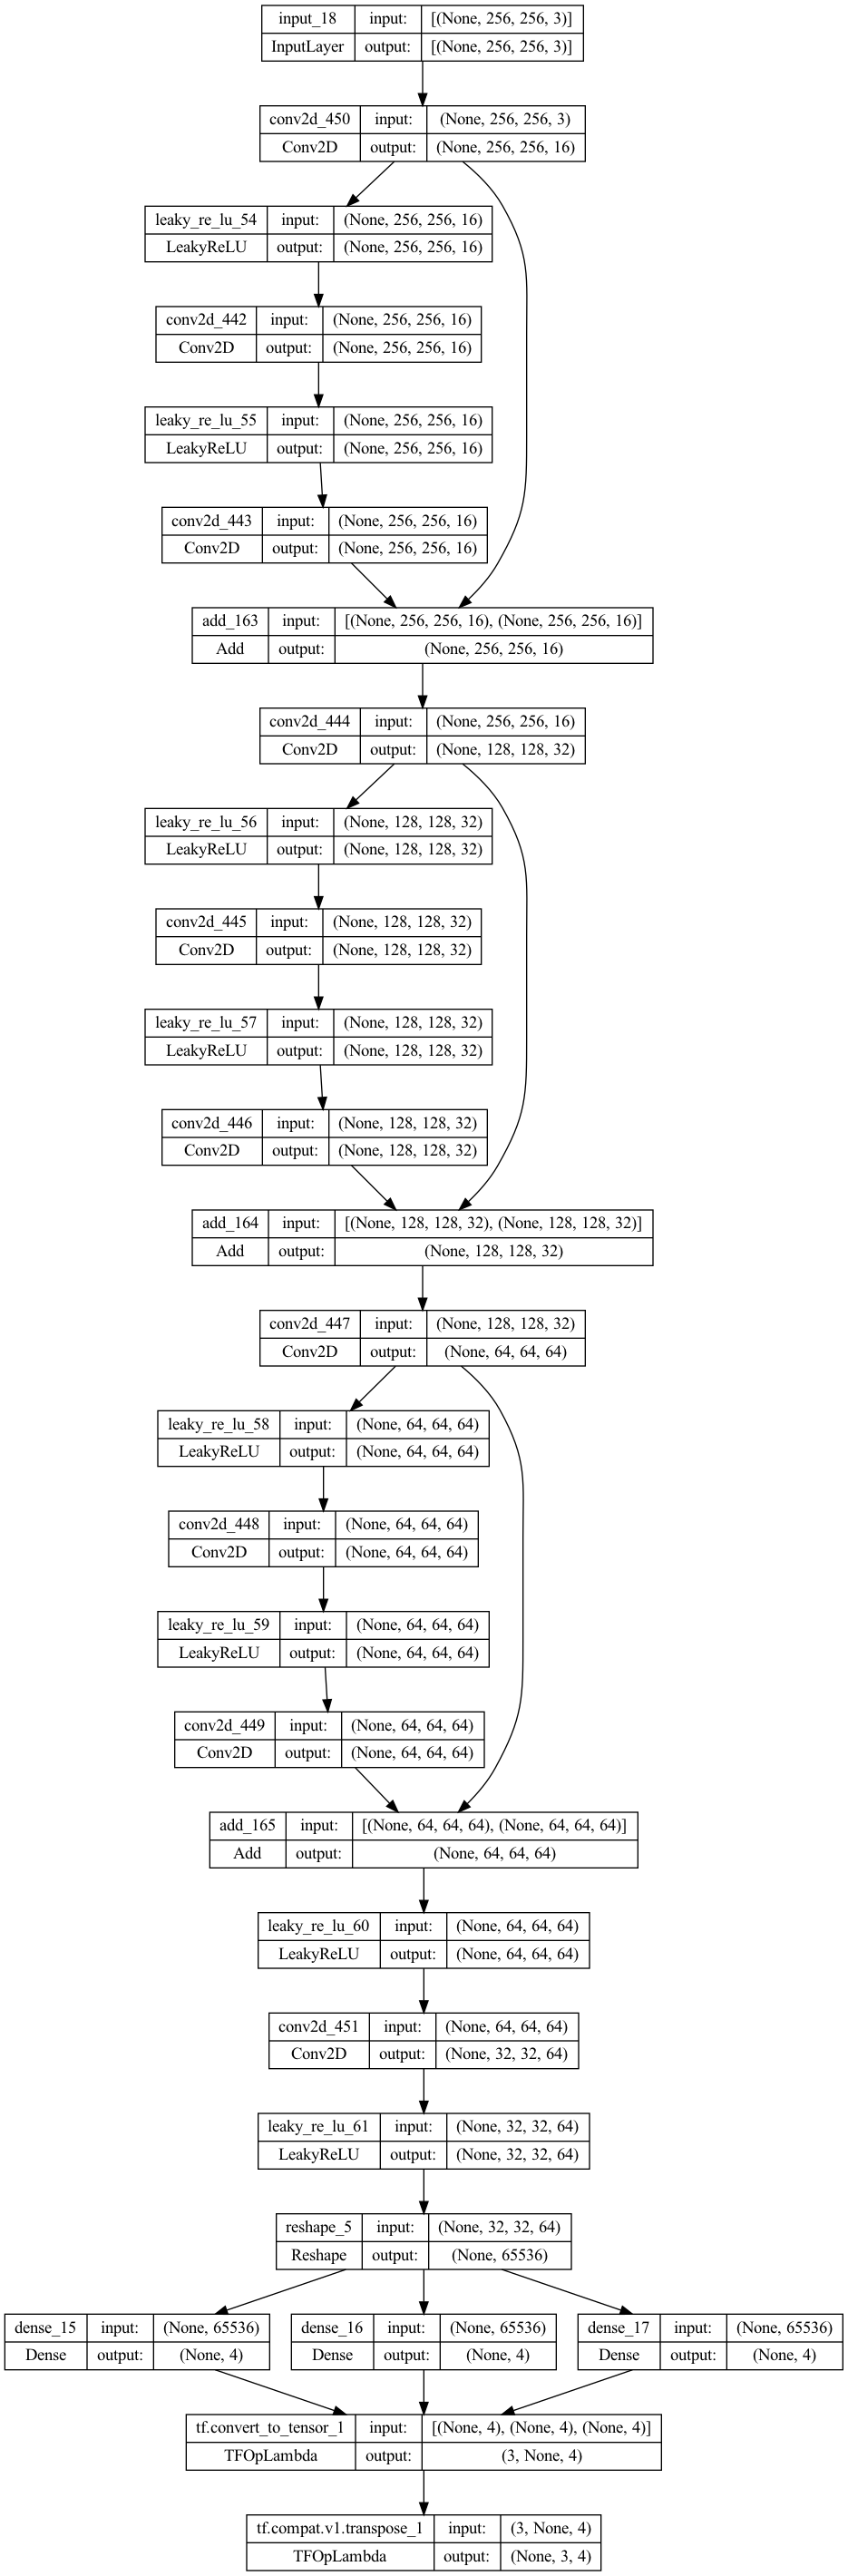

In [160]:
tf.keras.utils.plot_model(se1.build_graph(), show_shapes=True)

In [161]:
se1.build_graph().summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_450 (Conv2D)            (None, 256, 256, 16  64          ['input_19[0][0]']               
                                )                                                                 
                                                                                                  
 leaky_re_lu_54 (LeakyReLU)     (None, 256, 256, 16  0           ['conv2d_450[2][0]']             
                                )                                                          

#### Fixed model

In [4]:
class StyleEncoder(Model):
    
    def __init__(self, image_shape_in, num_channel, sc_dims, num_domains, kernel_size=3):
        super().__init__()
        
        self.image_shape_in = image_shape_in
        self.sc_dims = sc_dims
        self.num_channel = num_channel
        self.kernel_size = kernel_size
        
        # add layer(multiple for plot clarification)
        self.add1 = layers.Add()
        self.add2 = layers.Add()
        self.add3 = layers.Add()

        # in conv 1x1
        self.in_conv11 = layers.Conv2D(8, (1, 1),
                                        strides=(1, 1), padding='same',
                                        input_shape=(None, self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        # resblk 1 
        self.rb1_rl1 = layers.LeakyReLU()
        self.rb1_conv2d1 = layers.Conv2D(8, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb1_rl2 = layers.LeakyReLU()
        self.rb1_conv2d2 = layers.Conv2D(8, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 1
        self.ds1 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # resblk 2
        self.rb2_rl1 = layers.LeakyReLU()
        self.rb2_conv2d1 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb2_rl2 = layers.LeakyReLU()
        self.rb2_conv2d2 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 2
        self.ds2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')

        
        # resblk 3
        self.rb3_rl1 = layers.LeakyReLU()
        self.rb3_conv2d1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb3_rl2 = layers.LeakyReLU()
        self.rb3_conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 3
        self.ds3 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # final downsample
        self.fd_rl1 = layers.LeakyReLU()
        self.fd_ds = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        self.fd_rl2 = layers.LeakyReLU()
        
        # reshape for linear act
        self.rs_out = layers.Reshape((int(self.image_shape_in[0]/16.0)*int(self.image_shape_in[1]/16.0)*64,))
        
        # style code production
        self.sc_layers = []
        for i in range(num_domains):
            self.sc_layers.append(layers.Dense(sc_dims))
            
    def call(self, img_in):
        
        # conv 1x1
        x = self.in_conv11(img_in)
        
        # resblk 1
        x_res = self.rb1_conv2d1(self.rb1_rl1(x))
        x_res = self.rb1_conv2d2(self.rb1_rl2(x_res))
        x = self.add1([x, x_res])
        
        # resblk 1 downsample
        x = self.ds1(x)
        
        # resblk 2
        x_res = self.rb2_conv2d1(self.rb2_rl1(x))
        x_res = self.rb2_conv2d2(self.rb2_rl2(x_res))
        x = self.add2([x, x_res])
        
        # resblk 2 downsample
        x = self.ds2(x)
        
        # resblk 3
        x_res = self.rb3_conv2d1(self.rb3_rl1(x))
        x_res = self.rb3_conv2d2(self.rb3_rl2(x_res))
        x = self.add3([x, x_res])
        
        # resblk 3 downsample
        x = self.ds3(x)
        
        # final downsample
        x = self.fd_rl2(self.fd_ds(self.fd_rl1(x)))
        
        # reshape for linear act
        x = self.rs_out(x)
        
        # style code production
        scs = []
        for sc in self.sc_layers:
            scs.append(sc(x))
            
        return tf.transpose(tf.convert_to_tensor(scs), [1,0,2])
    
    def build_graph(self):
        x = layers.Input(shape=(self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        return Model(inputs=x, outputs=self.call(x))
        

#### Testing

In [19]:
se1 = StyleEncoder((256,256), 3, 4, 3)

In [20]:
for img, l in train_ds.take(1):
    s_ec_1 = se1(img)
    
print(s_ec_1)

tf.Tensor(
[[[  64.731      -65.96764    -59.159943    36.814163 ]
  [ -73.89253     10.1089325   42.55821      8.944504 ]
  [ -67.966805    32.564125    23.1129    -119.388306 ]]

 [[  53.40399     98.66672    -96.8373     -70.39624  ]
  [ -99.49669    -64.05858     24.265005    13.078075 ]
  [ -16.305447    -5.494409    10.483858   -76.30184  ]]], shape=(2, 3, 4), dtype=float32)


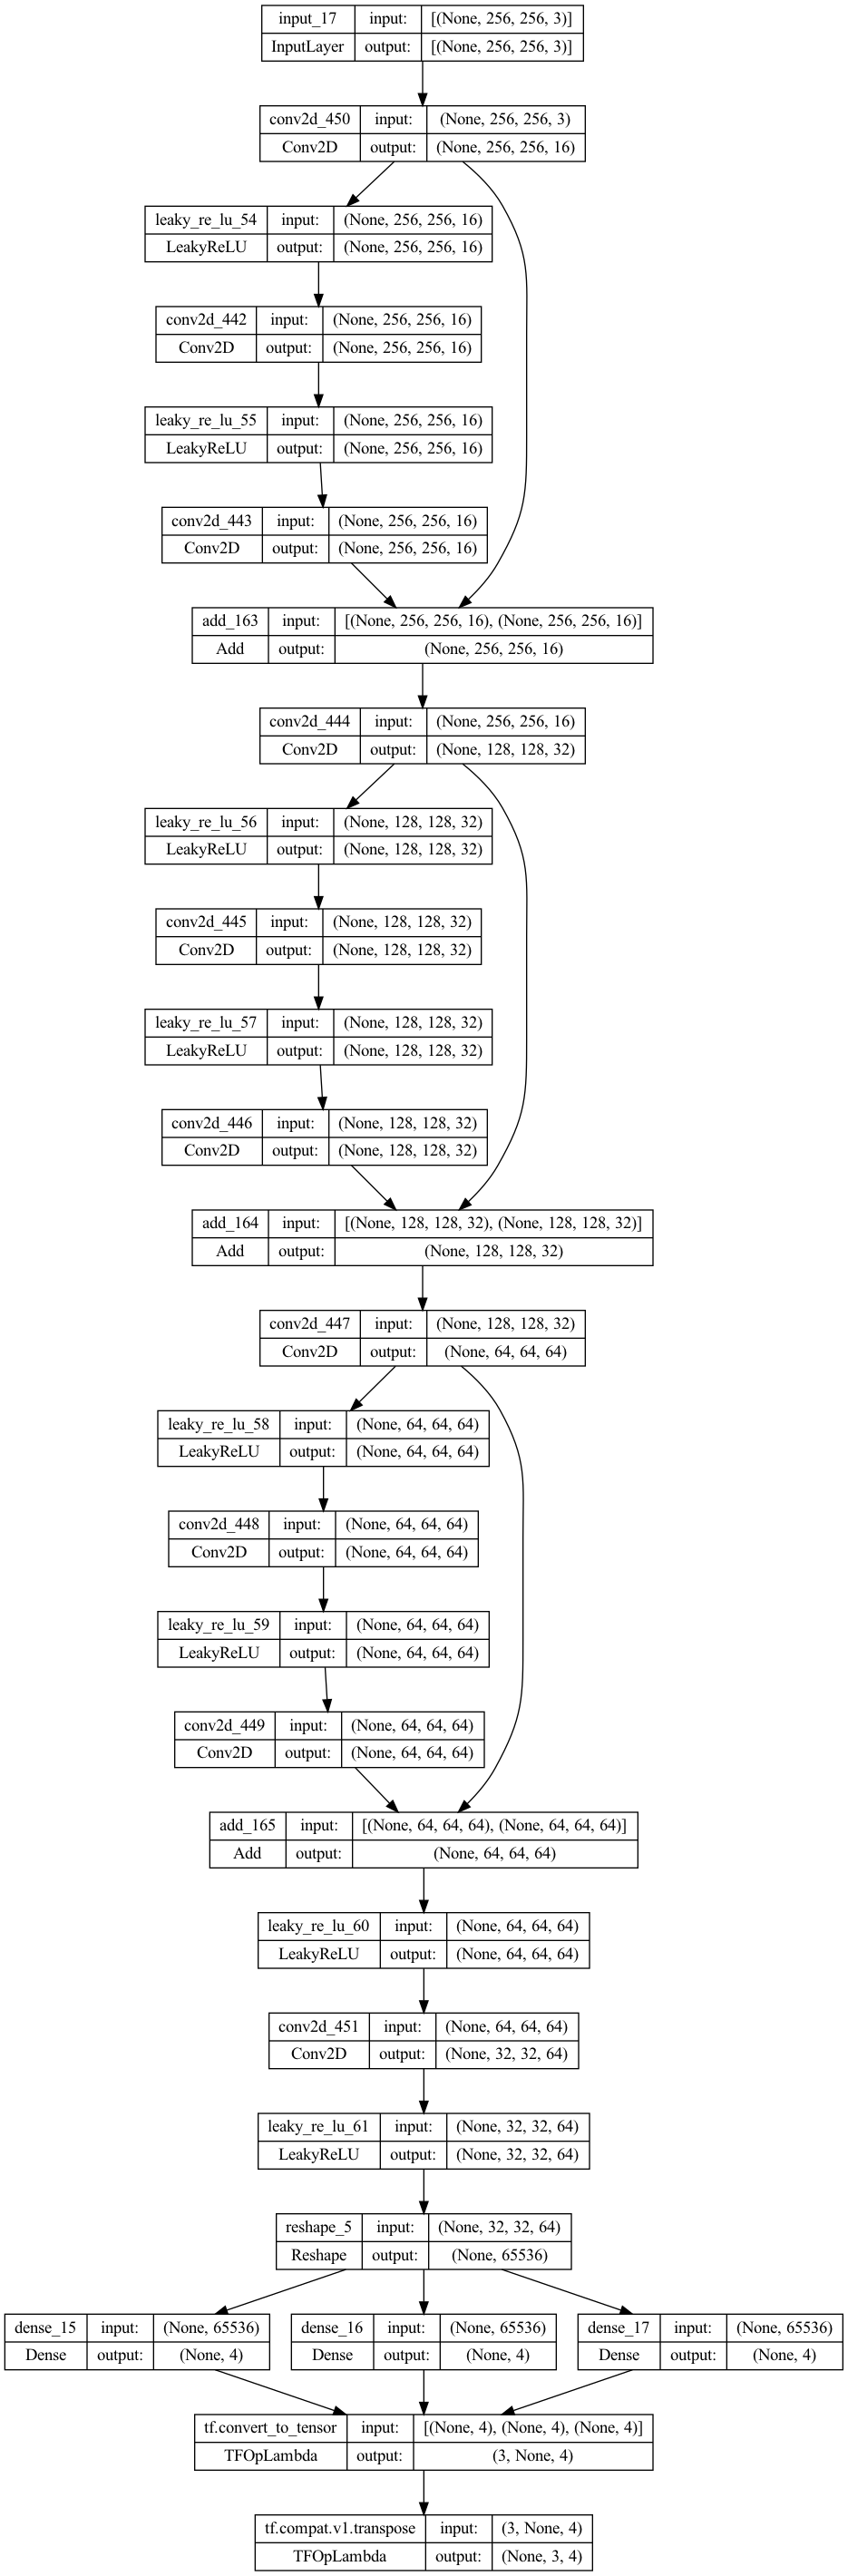

In [159]:
tf.keras.utils.plot_model(se1.build_graph(), show_shapes=True)

In [23]:
se1.build_graph().summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_16 (Conv2D)             (None, 256, 256, 8)  32          ['input_6[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 256, 256, 8)  0           ['conv2d_16[1][0]']              
                                                                                                  
 conv2d_17 (Conv2D)             (None, 256, 256, 8)  584         ['leaky_re_lu[1][0]']      

### Multi-domain Discriminator

#### Staged model

In [6]:
# ResBLKs require a couple of hyperparams: (filters, kernel size, downsample/upsample scale(strides)) 
# NOTE: 1. when staging, design kernel size/stride carefully
#       2. by design, please make sure models are built before called in tf.graphs to prevent retracing, build graph function is provided for such purpose

class MDDiscriminator(Model):
    
    def __init__(self, image_shape_in, num_channel, num_domains, num_out_filter=16,
                 stage_filters=(16, 32, 64), stage_kernels=(3, 3, 3),
                 stage_strides_ds=(2,2,0)):
        super().__init__()
        
        # staging params must be equal
        assert len(stage_filters) == len(stage_kernels)
        assert len(stage_filters) == len(stage_strides_ds)
        
        self.image_shape_in = image_shape_in
        self.num_channel = num_channel
        
        # ResBLK layers, downsample blk layers separated from upsample blk layers
        
        self.relus1_ds = []
        self.convs1_ds = []
        
        self.relus2_ds = []
        self.convs2_ds = []
        
        self.adds_ds = []
        self.dss = []

        for idx in range(len(stage_filters)):
            self.adds_ds.append(layers.Add())

            self.relus1_ds.append(layers.LeakyReLU())
            self.relus2_ds.append(layers.LeakyReLU())

            self.convs1_ds.append(layers.Conv2D(stage_filters[idx],(stage_kernels[idx],stage_kernels[idx]),
                                               strides=(1, 1), padding='same'))
            self.convs2_ds.append(layers.Conv2D(stage_filters[idx],(stage_kernels[idx],stage_kernels[idx]),
                                               strides=(1, 1), padding='same'))

            if stage_strides_ds[idx] == 0:
                self.dss.append(0)

            else:
                self.dss.append(layers.Conv2D(stage_filters[idx+1], (stage_kernels[idx],stage_kernels[idx]),
                                               strides=(stage_strides_ds[idx],stage_strides_ds[idx]), padding='same'))

        
        # in conv 1x1
        self.in_conv11 = layers.Conv2D(stage_filters[0], (1, 1),
                                        strides=(1, 1), padding='same',
                                        input_shape=(None, self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        # final downsample
        self.fd_rl1 = layers.LeakyReLU()
        self.fd_ds = layers.Conv2D(stage_filters[-1], (stage_kernels[-1],stage_kernels[-1]),
                                               strides=(2, 2), padding='same')
        self.fd_rl2 = layers.LeakyReLU()
        
        # reshape for linear act
        self.rs_out = layers.Reshape((int(self.image_shape_in[0]/(2**(len(stage_strides_ds))))*int(self.image_shape_in[1]/(2**(len(stage_strides_ds))))*stage_filters[-1],))
        
        # style code production
        self.rf_layers = []
        for i in range(num_domains):
            self.rf_layers.append(layers.Dense(num_out_filter))
            
    def call(self, img_in):
            
        # conv 1x1
        x = self.in_conv11(img_in)
        
        # downsample blks
        for idx in range(len(self.adds_ds)):
            x_res = self.convs1_ds[idx](self.relus1_ds[idx](x))
            x_res = self.convs2_ds[idx](self.relus2_ds[idx](x_res))
            x = self.adds_ds[idx]([x, x_res])
            if not self.dss[idx]==0:
                x = self.dss[idx](x)
                

        # final downsample
        x = self.fd_rl2(self.fd_ds(self.fd_rl1(x)))
        
        # reshape for linear act
        x = self.rs_out(x)
        
        rfs = []
        for rf in self.rf_layers:
            rfs.append(rf(x))
        
        return tf.transpose(tf.convert_to_tensor(rfs), [1,0,2])
    
    def build_graph(self):
        x = layers.Input(shape=(self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        return Model(inputs=x, outputs=self.call(x))
        
        

#### Testing

In [166]:
mdd1 = MDDiscriminator((256,256), 3, 3)

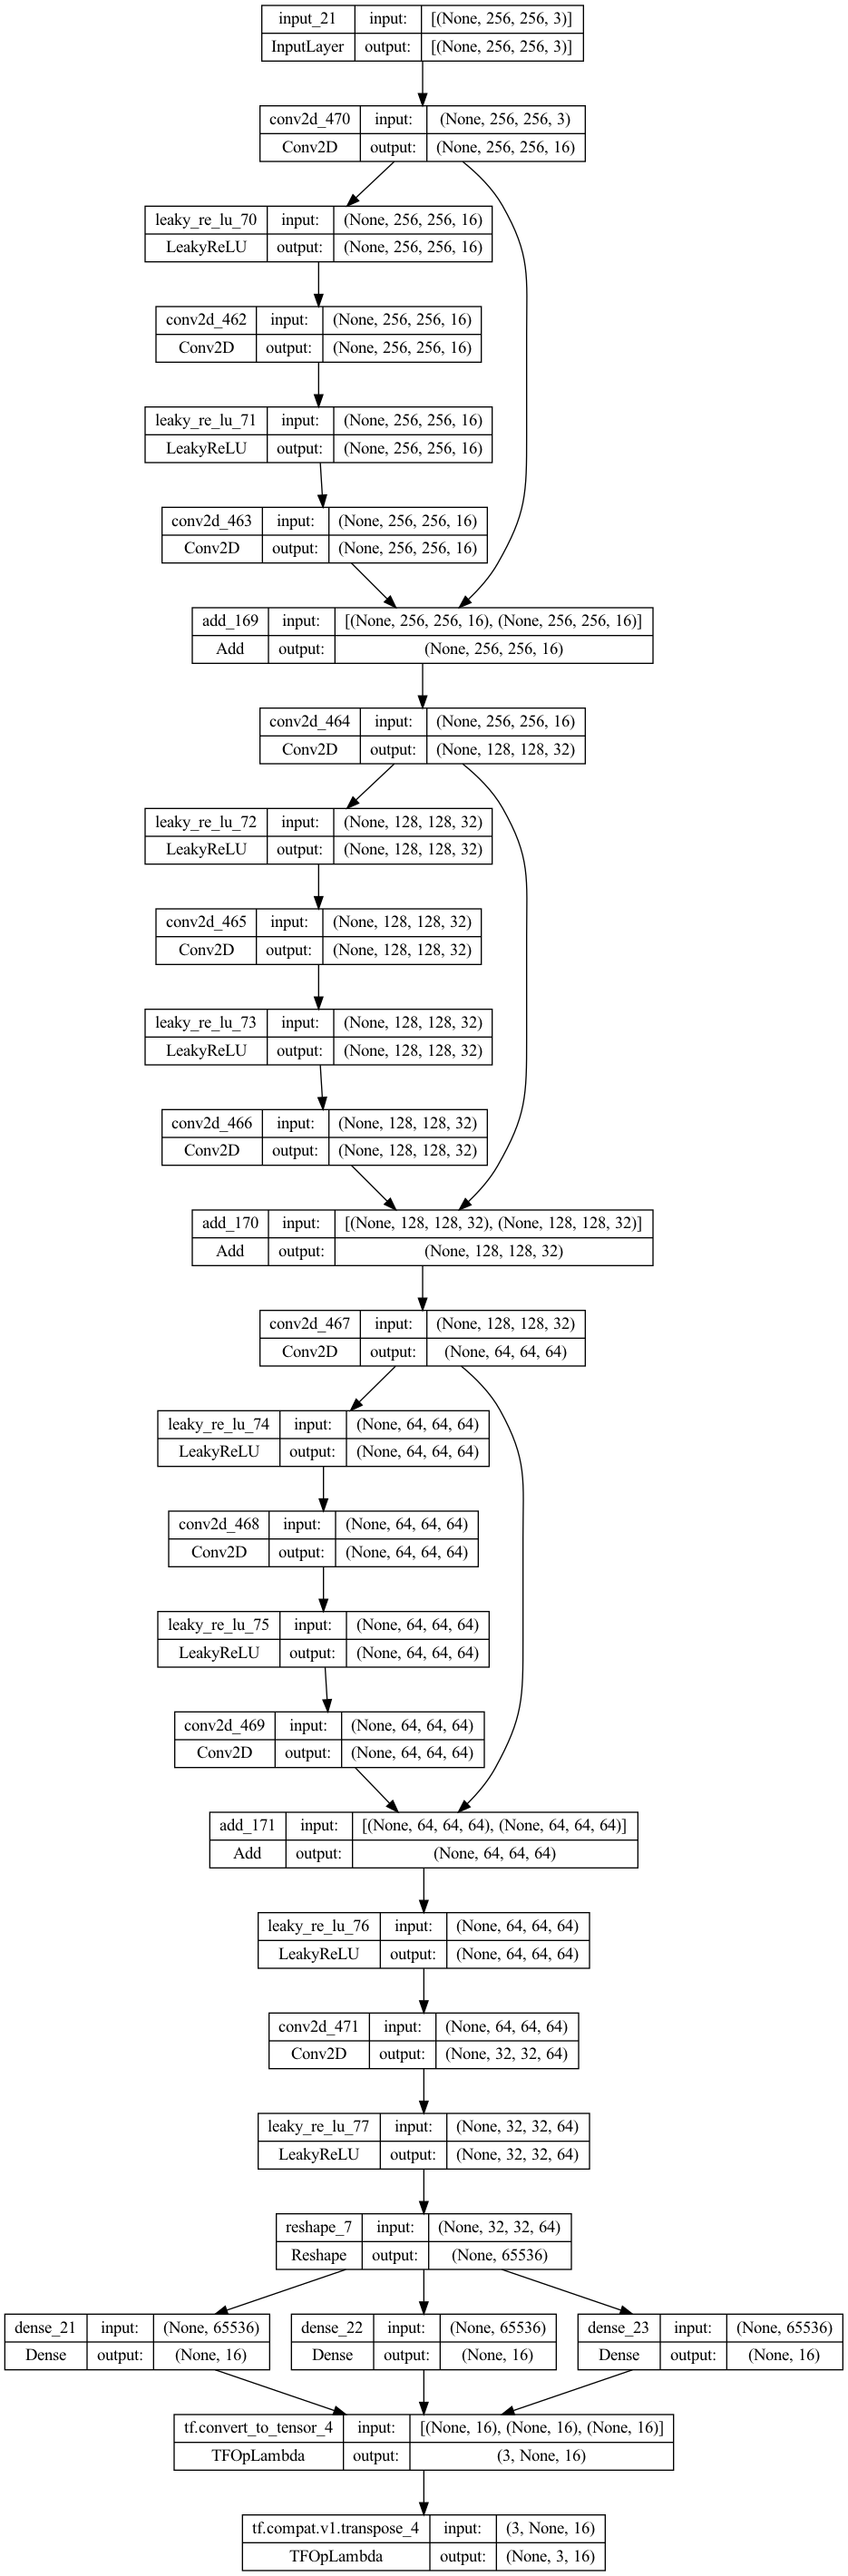

In [167]:
tf.keras.utils.plot_model(mdd1.build_graph(), show_shapes=True)

#### Fixed model

In [5]:
class MDDiscriminator(Model):
    
    def __init__(self, image_shape_in, num_channel, num_domains, num_out_filter=16, kernel_size=3):
        super().__init__()
        
        self.image_shape_in = image_shape_in
        self.num_channel = num_channel
        self.kernel_size = kernel_size
        
        # add layer(multiple for plot clarification)
        self.add1 = layers.Add()
        self.add2 = layers.Add()
        self.add3 = layers.Add()

        # in conv 1x1
        self.in_conv11 = layers.Conv2D(8, (1, 1),
                                        strides=(1, 1), padding='same',
                                        input_shape=(None, self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        # resblk 1 
        self.rb1_rl1 = layers.LeakyReLU()
        self.rb1_conv2d1 = layers.Conv2D(8, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb1_rl2 = layers.LeakyReLU()
        self.rb1_conv2d2 = layers.Conv2D(8, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 1
        self.ds1 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # resblk 2
        self.rb2_rl1 = layers.LeakyReLU()
        self.rb2_conv2d1 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb2_rl2 = layers.LeakyReLU()
        self.rb2_conv2d2 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 2
        self.ds2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')

        
        # resblk 3
        self.rb3_rl1 = layers.LeakyReLU()
        self.rb3_conv2d1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb3_rl2 = layers.LeakyReLU()
        self.rb3_conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 3
        self.ds3 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # final downsample
        self.fd_rl1 = layers.LeakyReLU()
        self.fd_ds = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        self.fd_rl2 = layers.LeakyReLU()
        
        # reshape for linear act
        self.rs_out = layers.Reshape((int(self.image_shape_in[0]/16.0)*int(self.image_shape_in[1]/16.0)*64,))
        
        self.rf_layers = []
        for i in range(num_domains):
            self.rf_layers.append(layers.Dense(num_out_filter))
            
    def call(self, img_in):
        
        # conv 1x1
        x = self.in_conv11(img_in)
        
        # resblk 1
        x_res = self.rb1_conv2d1(self.rb1_rl1(x))
        x_res = self.rb1_conv2d2(self.rb1_rl2(x_res))
        x = self.add1([x, x_res])
        
        # resblk 1 downsample
        x = self.ds1(x)
        
        # resblk 2
        x_res = self.rb2_conv2d1(self.rb2_rl1(x))
        x_res = self.rb2_conv2d2(self.rb2_rl2(x_res))
        x = self.add2([x, x_res])
        
        # resblk 2 downsample
        x = self.ds2(x)
        
        # resblk 3
        x_res = self.rb3_conv2d1(self.rb3_rl1(x))
        x_res = self.rb3_conv2d2(self.rb3_rl2(x_res))
        x = self.add3([x, x_res])
        
        # resblk 3 downsample
        x = self.ds3(x)
        
        # final downsample
        x = self.fd_rl2(self.fd_ds(self.fd_rl1(x)))
        
        # reshape for linear act
        x = self.rs_out(x)
        
        # style code production
        rfs = []
        for rf in self.rf_layers:
            rfs.append(rf(x))
        
        return tf.transpose(tf.convert_to_tensor(rfs), [1,0,2])
    
    def build_graph(self):
        x = layers.Input(shape=(self.image_shape_in[0],
                                        self.image_shape_in[1], self.num_channel))
        
        return Model(inputs=x, outputs=self.call(x))
        

#### Testing

In [25]:
mdd1 = MDDiscriminator((256,256), 3, 3)

In [26]:
for img, l in train_ds.take(1):
    ds = mdd1(img)
print(ds)

tf.Tensor(
[[[-7.4469406e+01 -4.7098082e-01 -1.7703308e+01  3.1713104e+01
   -2.4702900e+01  1.5384492e+01 -3.0802643e+00 -2.3913874e+01
    4.0312333e+00 -2.8035702e+01 -2.4434761e+01  2.5648388e+01
   -1.1087315e+01 -2.6316383e-01 -3.0450668e+01  2.7333092e+01]
  [ 1.8766975e+01 -1.0009925e+01 -1.4693942e+01 -2.0565380e+01
   -3.4913712e+01  2.8123812e+01 -1.9199707e+01  2.4036551e+01
    1.3732402e+01  7.3071685e+00 -2.0298401e+01 -1.9379307e+01
   -1.0389234e+01 -4.5794266e+01 -2.9148857e+01  2.0734239e+00]
  [ 1.2701879e+01 -5.8299041e+00 -1.7412447e+01  1.2280455e+01
   -2.1368759e+01 -1.9836830e+01  4.6953129e+01 -3.7218288e+01
    8.9626341e+00 -2.9771103e+01 -4.1992698e+00  2.3979210e+01
   -1.9151600e+01  5.9264214e+01 -1.2705970e+01 -1.1120226e+01]]

 [[-2.8230923e+01 -1.7634995e+01 -1.6056471e+00  1.7691641e+01
    3.9672357e-01  1.7709017e-02  7.2611523e+00  3.7398837e+00
    7.1632271e+00 -3.9565689e+01  7.7560229e+00  2.0495661e+01
   -1.0275899e+01  1.2797376e+00 -4.711

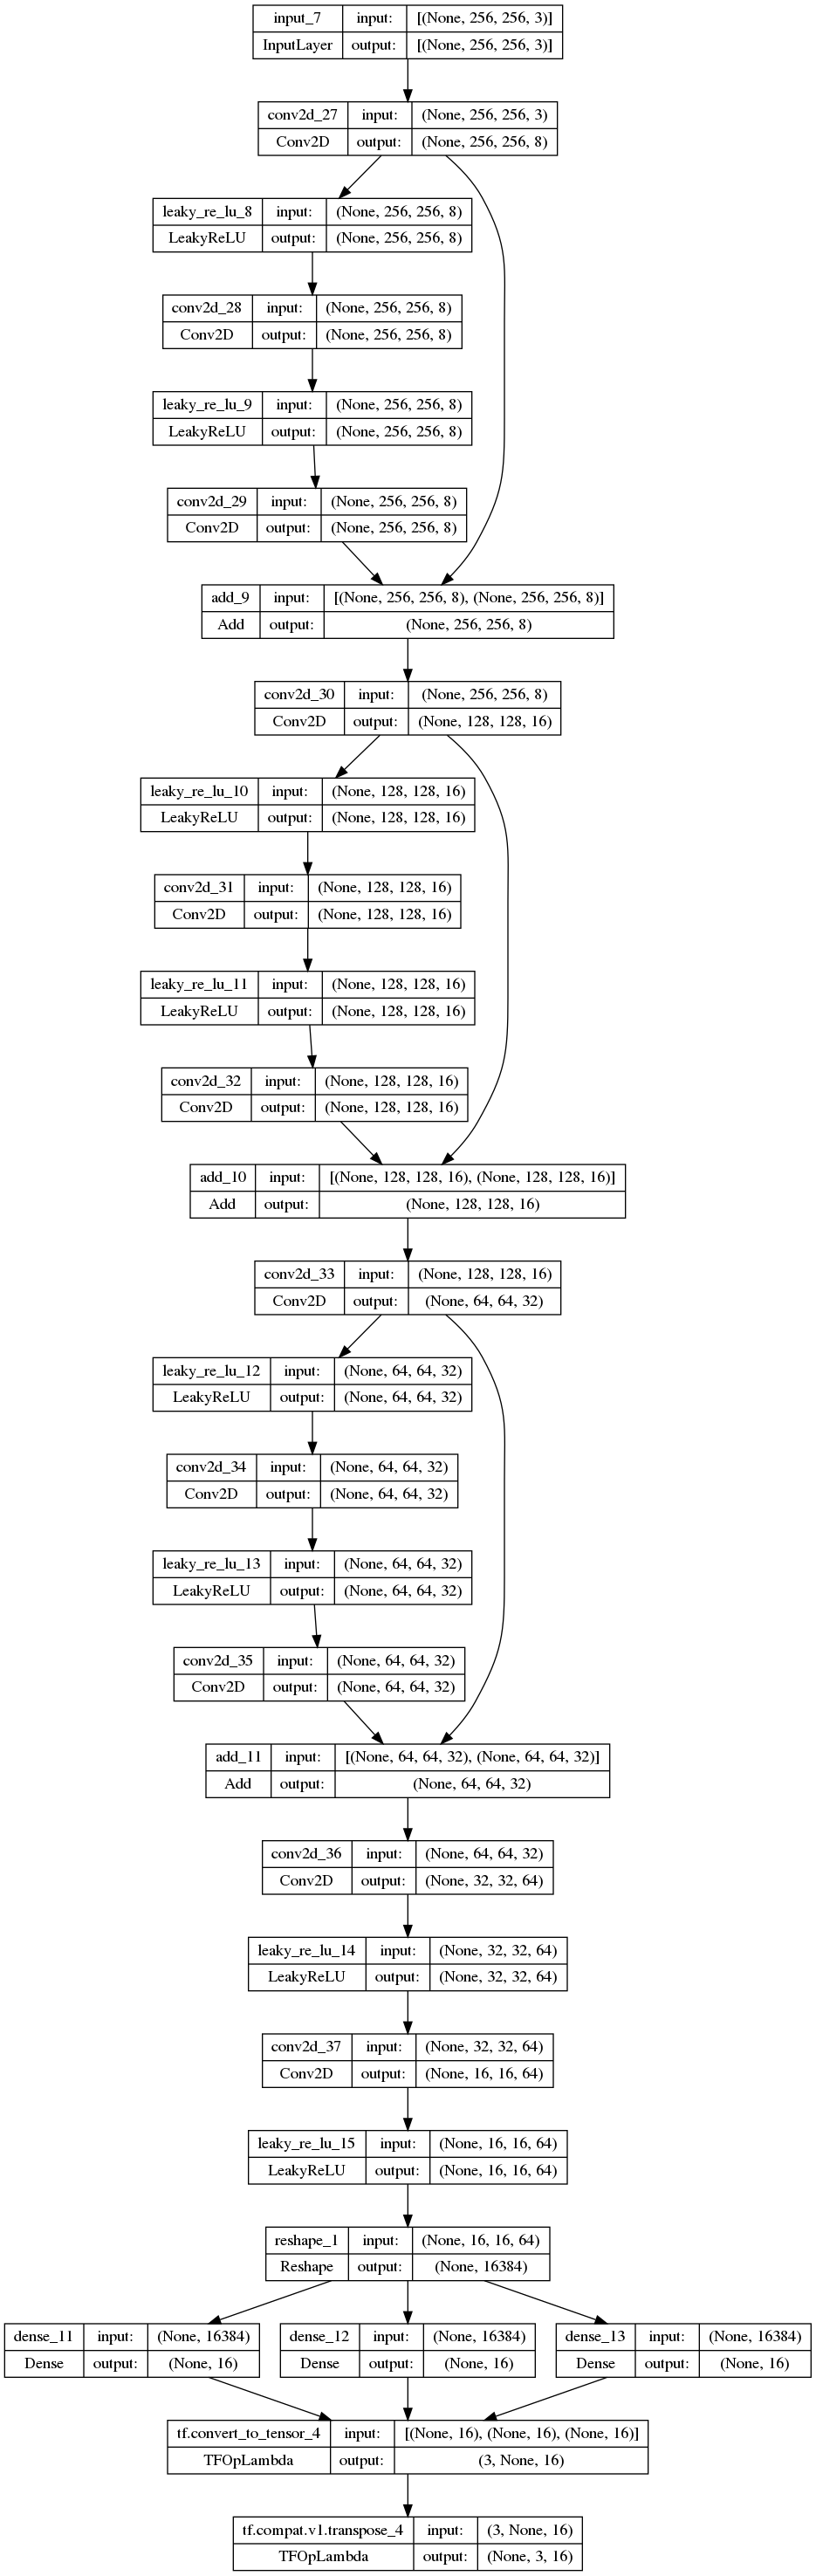

In [28]:
tf.keras.utils.plot_model(mdd1.build_graph(), show_shapes=True)

In [29]:
mdd1.build_graph().summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_27 (Conv2D)             (None, 256, 256, 8)  32          ['input_8[0][0]']                
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 256, 256, 8)  0           ['conv2d_27[1][0]']              
                                                                                                  
 conv2d_28 (Conv2D)             (None, 256, 256, 8)  584         ['leaky_re_lu_8[1][0]']    

### StarGAN-v2

In [1]:
EPSILON = 1e-16

class StarGAN2:
    
    def __init__(self, dataset_path, image_shape, num_channel, noise_latent_dim, sc_dim,
                 gen_staging_params=None, se_staging_params=None, disc_staging_params=None,
                 num_out_filter=16, disc_update_multi=5, 
                 batch_size=128, lr=3e-4, gp_lam=10.0, sty_lam=1.0, ds_lam=1.0, cyc_lam=1.0):
        assert len(image_shape) == 2
        assert image_shape[0]%16 == 0
        assert image_shape[1]%16 == 0
            
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.noise_latent_dim = noise_latent_dim
        self.sc_dim = sc_dim
        self.batch_size, self.gp_lam, self.sty_lam, self.ds_lam, self.cyc_lam = batch_size, gp_lam, sty_lam, ds_lam, cyc_lam
        self.disc_update_multi = disc_update_multi
        self.num_domains = 1
        if not dataset_path==None:
            self.dataset = tf.keras.utils.image_dataset_from_directory(
                                  dataset_path,
                                  seed=123,
                                  image_size=self.image_shape,
                                  batch_size=self.batch_size)
            self.num_domains = len(self.dataset.class_names)
        else:
            print("WARNING: Dataset not loaded, Model in Generator mode")
        # NOTE: Dataset must be processed differently for different source and applications
        
        if not gen_staging_params == None:
            stage_filters, stage_kernels, stage_strides_ds, stage_strides_us = gen_staging_params
            self.g = Generator(self.image_shape, self.num_channel, stage_filters=stage_filters, stage_kernels=stage_kernels,
                 stage_strides_ds=stage_strides_ds, stage_strides_us=stage_strides_us)
        else: 
            self.g = Generator(self.image_shape, self.num_channel)
            
        self.f = Mapper(self.noise_latent_dim, self.sc_dim, self.num_domains)
        
        if not se_staging_params == None:
            stage_filters, stage_kernels, stage_strides_ds = se_staging_params
            self.e = StyleEncoder(self.image_shape, self.num_channel, self.sc_dim, self.num_domains, stage_filters=stage_filters, stage_kernels=stage_kernels,
                 stage_strides_ds=stage_strides_ds)
        else:
            self.e = StyleEncoder(self.image_shape, self.num_channel, self.sc_dim, self.num_domains)
            
        if not disc_staging_params == None:
            stage_filters, stage_kernels, stage_strides_ds = disc_staging_params
            self.d = MDDiscriminator(self.image_shape, self.num_channel, self.num_domains, num_out_filter=num_out_filter, stage_filters=stage_filters, stage_kernels=stage_kernels,
                 stage_strides_ds=stage_strides_ds)
        else:
            self.d = MDDiscriminator(self.image_shape, self.num_channel, self.num_domains, num_out_filter=num_out_filter)
        
        self.g_opt = tf.keras.optimizers.Adam(lr)
        self.f_opt = tf.keras.optimizers.Adam(lr)
        self.e_opt = tf.keras.optimizers.Adam(lr)
        self.d_opt = tf.keras.optimizers.Adam(lr)

    def adv_loss(self, dty_xt, dty_gs1, dty_gs2):
        
        crit_xt = tf.math.add(tf.math.sqrt(tf.reduce_sum(tf.math.add(dty_xt, -dty_gs2)**2, axis = 1)+EPSILON),
                   -tf.math.sqrt(tf.reduce_sum(dty_xt**2, axis = 1)+EPSILON))
        
        crit_gs1 = tf.math.add(tf.math.sqrt(tf.reduce_sum(tf.math.add(dty_gs1, -dty_gs2)**2, axis = 1)+EPSILON),
                   -tf.math.sqrt(tf.reduce_sum(dty_gs1**2, axis = 1)+EPSILON))

        # adv_loss
        L_adv = tf.math.add(crit_xt, -crit_gs1)

        return tf.reduce_mean(L_adv)
    
    def gp_loss(self, xty_it, dty_xt, dty_gs2, tls):
        
        with tf.GradientTape() as t_gp:
            t_gp.watch(xty_it)
            dty_xit = tf.gather_nd(self.d(xty_it), tls)
            fty_xit = tf.math.add(tf.math.sqrt(tf.reduce_sum(tf.math.add(dty_xit, -dty_gs2)**2, axis = 1)+EPSILON),
                   -tf.math.sqrt(tf.reduce_sum(tf.math.add(dty_xit, -dty_xt)**2, axis = 1)+EPSILON))
            
        gp_grad = t_gp.gradient(fty_xit, xty_it)
        l2n_gp = tf.math.sqrt(tf.reduce_sum(gp_grad**2, axis = [1,2,3])+EPSILON)
        L_gp = (l2n_gp-1.0)**2
        
        return tf.reduce_mean(L_gp)
    
    def ds_loss(self, g_s1, g_s2):
        
        L_ds = tf.math.sqrt(tf.reduce_sum(tf.math.add(g_s1, -g_s2)**2, axis = [1,2,3])+EPSILON)

        return tf.reduce_mean(L_ds)
       
    def cyc_loss(self, imgs, styrec_g1, styrec_g2):
        
        l2nxygs1 = tf.math.sqrt(tf.reduce_sum(tf.math.add(imgs, -styrec_g1)**2, axis = [1,2,3])+EPSILON)
        l2nxygs2 = tf.math.sqrt(tf.reduce_sum(tf.math.add(imgs, -styrec_g2)**2, axis = [1,2,3])+EPSILON)
        
        L_cyc = l2nxygs1+l2nxygs2
        
        return tf.reduce_mean(L_cyc)
    
    def sty_loss(self, s_hat1, s_hat2, ety_gs1, ety_gs2):
        
        l2ns1 = tf.math.sqrt(tf.reduce_sum(tf.math.add(s_hat1, -ety_gs1)**2, axis = 1)+EPSILON)
        l2ns2 = tf.math.sqrt(tf.reduce_sum(tf.math.add(s_hat2, -ety_gs2)**2, axis = 1)+EPSILON)

        L_sty = l2ns1+l2ns2
        
        return tf.reduce_mean(L_sty)

    def apply_gradients(self, tapes, Ls):
        
        g_tape, d_tape, f_tape, e_tape = tapes
        L_gf, L_d, L_e = Ls
        
        grad_g = g_tape.gradient(L_gf, self.g.trainable_variables)
        grad_d = d_tape.gradient(L_d, self.d.trainable_variables)
        grad_f = f_tape.gradient(L_gf, self.f.trainable_variables)
        grad_e = e_tape.gradient(L_e, self.e.trainable_variables)
        
        self.g_opt.apply_gradients(zip(grad_g, self.g.trainable_variables))
        self.d_opt.apply_gradients(zip(grad_d, self.d.trainable_variables))
        self.f_opt.apply_gradients(zip(grad_f, self.f.trainable_variables))
        self.e_opt.apply_gradients(zip(grad_e, self.e.trainable_variables))
    
    @tf.function()
    def update(self, imgs, ls, timgs, tls, update_gen=True):
        
        noise_input1 = tf.random.normal((imgs.shape[0], self.noise_latent_dim))
        noise_input2 = tf.random.normal((imgs.shape[0], self.noise_latent_dim))
        
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape, tf.GradientTape() as f_tape, tf.GradientTape() as e_tape:
            s_hat1 = tf.gather_nd(self.f(noise_input1), tls)
            s_hat2 = tf.gather_nd(self.f(noise_input2), tls)
            
            g_s1 = self.g(imgs, s_hat1)
            g_s2 = self.g(imgs, s_hat2)
            
            dy_xy = tf.gather_nd(self.d(imgs), ls)
            dty_xt = tf.gather_nd(self.d(timgs), tls)

            dty_gs1 = tf.gather_nd(self.d(g_s1), tls)
            dty_gs2 = tf.gather_nd(self.d(g_s2), tls)

            epsi = tf.random.uniform([timgs.shape[0], 1, 1, 1], 0.0, 1.0)
            xty_it = tf.math.add(epsi*timgs, (1.0-epsi)*g_s1)
#             dty_xit = self.take_domain_output(self.d(xty_it), tls)
            
            ey_xy = tf.gather_nd(self.e(imgs), ls)
            styrec_g1 = self.g(g_s1, ey_xy)
            styrec_g2 = self.g(g_s2, ey_xy)
            dy_styrecg1 = tf.gather_nd(self.d(styrec_g1), ls)
            
            ety_gs1 = tf.gather_nd(self.e(g_s1), tls)
            ety_gs2 = tf.gather_nd(self.e(g_s2), tls)
            
            adv_loss = self.adv_loss(dty_xt, dty_gs1, dty_gs2)
            gp_loss = self.gp_loss(xty_it, dty_xt, dty_gs2, tls)
            ds_loss = self.ds_loss(g_s1, g_s2)
            cyc_loss = self.cyc_loss(imgs, styrec_g1, styrec_g2)
            sty_loss = self.sty_loss(s_hat1, s_hat2, ety_gs1, ety_gs2)
            
            L_gf = adv_loss-self.ds_lam*ds_loss+self.cyc_lam*cyc_loss+self.sty_lam*sty_loss
            L_d = -adv_loss+self.gp_lam*gp_loss
            L_e = self.cyc_lam*cyc_loss+self.sty_lam*sty_loss
            
#         if update_gen:
        self.apply_gradients((g_tape, d_tape, f_tape, e_tape), (L_gf, L_d, L_e))


#         else:
#             grad_d = d_tape.gradient(d_loss, self.d.trainable_variables)
#             self.d_opt.apply_gradients(zip(grad_d, self.d.trainable_variables))

        return adv_loss, gp_loss, ds_loss, cyc_loss, sty_loss
        
    def train(self, epochs=250):
        num_training = 0
        for epo in range(epochs):
            adv_losses = []
            gp_losses = []
            ds_losses = []
            cyc_losses = []
            sty_losses = []
            for img_b, l_b in self.dataset:
                if not img_b.shape[0] == self.batch_size:
                    break
                if self.num_channel == 1 and img_b.shape[-1] == 3:
                    img_b = tf.image.rgb_to_grayscale(img_b)
                    
                img_b = (img_b-127.5)/127.5 
                l_b = tf.constant([[i, l_b[i].numpy()] for i in range(self.batch_size)])
                
                for timg_b, tl_b in self.dataset.take(1):
                    if self.num_channel == 1 and img_b.shape[-1] == 3:
                        timg_b = tf.image.rgb_to_grayscale(timg_b)
                        
                    timg_b = (timg_b-127.5)/127.5 
                    tl_b = tf.constant([[i, tl_b[i].numpy()] for i in range(self.batch_size)])
                
                a_l, g_l, d_l, c_l, s_l = self.update(img_b, l_b, timg_b, tl_b)

                adv_losses.append(a_l.numpy())
                gp_losses.append(g_l.numpy())
                ds_losses.append(d_l.numpy())
                cyc_losses.append(c_l.numpy())
                sty_losses.append(s_l.numpy())
#                 if num_training%self.disc_update_multi == 0:     
#                 else:    
                num_training = (num_training+1)%self.disc_update_multi
                
            print("Epoch {:04d}".format(epo), "Avg. Adv Loss: ", np.mean(adv_losses), 
                  ", Avg. GP Loss: ",  np.mean(gp_losses),
                  ", Avg. DS Loss: ",  np.mean(ds_losses), 
                  ", Avg. CYC Loss: ",  np.mean(cyc_losses), 
                  ", Avg. STY Loss: ",  np.mean(sty_losses), flush=True)

            
    def save_weights(self, dir_path):
        self.g.save_weights(dir_path+"/g.ckpt")
        print("Saved generator weights", flush=True)
        self.d.save_weights(dir_path+"/d.ckpt")
        print("Saved discriminator weights", flush=True)
        self.f.save_weights(dir_path+"/f.ckpt")
        print("Saved mapping network weights", flush=True)
        self.e.save_weights(dir_path+"/e.ckpt")
        print("Saved style encoder weights", flush=True)
        
    def load_weights(self, dir_path):
        try:
            self.g.load_weights(dir_path+"/g.ckpt")
            print("Loaded generator weights", flush=True)
            self.d.load_weights(dir_path+"/d.ckpt")
            print("Loaded discriminator weights", flush=True)
            self.f.load_weights(dir_path+"/f.ckpt")
            print("Loaded mapping network weights", flush=True)
            self.e.load_weights(dir_path+"/e.ckpt")
            print("Loaded style encoder weights", flush=True)
        except ValueError:
            print("ERROR: Please make sure weights are saved as .ckpt", flush=True)
    
    def generate_sample(self, path, src, ref=None, t_d=0):
        src_path, src_d = src

        src_ib = tf.io.read_file(src_path)
        src_img = tf.image.decode_jpeg(src_ib, channels=self.num_channel)
        src_img = tf.expand_dims(tf.image.resize(src_img, (256,256)),0)
        src_d = tf.constant([0,src_d])
        
        if not ref==None:
            ref_path, ref_d = ref
            ref_ib = tf.io.read_file(ref_path)
            ref_img = tf.image.decode_jpeg(ref_ib, channels=self.num_channel)
            ref_img = tf.expand_dims(tf.image.resize(ref_img, (256,256)),0)
            ref_d = tf.constant([0,ref_d])
            
            sc = tf.gather_nd(self.e(ref_img), ref_d)
            
            samp = self.g(src_img, sc)
            
        else:
            t_d = tf.constant([0,t_d])
            samp_noise = tf.random.normal((1,self.noise_latent_dim))
            sc = tf.gather_nd(self.f(samp_noise), t_d)
                         
            samp = self.g(src_img, sc)

        if self.num_channel == 1:
            plt.imshow(samp[0,:,:,0], cmap='gray')
        else:   
            plt.imshow(tf.cast(tf.math.round(samp[0,:,:,:]*127.5+127.5), tf.int32))
        plt.axis('off')
        plt.savefig(path+'/sample_image.png')
        plt.close('all')
            

NameError: name 'tf' is not defined

### Testing

In [46]:
t_d = tf.constant([0,1])
samp_noise = tf.random.normal((1,16))

In [50]:
sc = mapper1(samp_noise)
print(sc)
sc = tf.gather_nd(sc, t_d)
print(sc)

tf.Tensor(
[[[-0.09852672 -0.03300349  0.21872206  0.4228451 ]
  [-0.05517299 -0.08333226  0.07919971 -0.04694375]
  [ 0.00157756 -0.01565972 -0.01020448  0.00813705]]], shape=(1, 3, 4), dtype=float32)
tf.Tensor([-0.05517299 -0.08333226  0.07919971 -0.04694375], shape=(4,), dtype=float32)


In [53]:
samp = g_t(tf.expand_dims(src_img, 0), sc)
print(samp)

tf.Tensor(
[[[[  5.038164     5.527397    -0.09045911]
   [  9.507071     5.2913055   -1.8045151 ]
   [-10.10219      0.7843063   -4.3453693 ]
   ...
   [ -5.5115824   -7.5719814    4.228006  ]
   [ -1.8698866    5.387386     5.0962157 ]
   [ -2.004359     0.2943902    4.377137  ]]

  [[  6.422662    -2.2834558    6.872904  ]
   [ -3.58962     -6.2885303    2.0698402 ]
   [ 10.242519     8.282803    -2.572261  ]
   ...
   [ -0.10990429  -1.4915302    0.6950023 ]
   [ -6.581874    10.912637     2.5139208 ]
   [ -2.770565    -1.2856784   -4.6153126 ]]

  [[ -1.8503871   -8.464854    -0.9965234 ]
   [ -6.5692816   -5.1352944    2.3762414 ]
   [  9.62628      5.290969    10.618137  ]
   ...
   [ -0.849452     0.5721886    1.4311057 ]
   [ -4.8099203   18.424406    -5.9582763 ]
   [  3.474039    -3.4315472    3.2167869 ]]

  ...

  [[ -9.082641     8.184641    -6.0720935 ]
   [ -7.203682   -15.595812     5.406046  ]
   [  0.55147946  20.22796     -7.1011996 ]
   ...
   [  9.730613     7.735

In [57]:
src = ("/Users/anthonylaw/Desktop/Endless/GAN-devel/datasets/afhq/val/cat/flickr_cat_000008.jpg", 0)
ref = ("/Users/anthonylaw/Desktop/Endless/GAN-devel/datasets/afhq/val/dog/pixabay_dog_001098.jpg", 1)

In [58]:
src_path, src_d = src
ref_path, ref_d = ref

In [42]:
g_t = Generator((256,256),3)
se1 = StyleEncoder((256,256), 3, 4, 3)
mapper1 = Mapper(16, 4, 3)

In [22]:
src_ib = tf.io.read_file(src_path)
src_img = tf.image.decode_jpeg(src_ib, channels=3)
src_img=tf.image.resize(src_img, (256,256))
print(src_img.shape)

(256, 256, 3)


In [23]:
ref_ib = tf.io.read_file(ref_path)
ref_img = tf.image.decode_jpeg(ref_ib, channels=3)
ref_img=tf.image.resize(ref_img, (256,256))
print(ref_img.shape)

(256, 256, 3)


In [32]:
sc = se1(tf.expand_dims(ref_img, 0))

In [30]:
ref_d = tf.constant([0,ref_d])

In [33]:
sc = tf.gather_nd(sc, ref_d)

In [35]:
samp = g_t(tf.expand_dims(src_img, 0), sc)

In [37]:
samp[0]

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[ -17.058592  ,   -9.860952  ,  -47.156586  ],
        [ -91.986786  ,  -17.587158  ,   -4.772995  ],
        [  14.418896  ,  -50.079803  ,    3.9678802 ],
        ...,
        [ -44.754784  ,  -51.065647  ,    7.8110485 ],
        [ -33.542038  ,  -36.521587  ,  -53.162308  ],
        [ -99.016754  ,  -18.63922   ,   49.700405  ]],

       [[  52.765923  ,    5.146906  ,  -41.62882   ],
        [ -28.42824   ,  -88.34436   ,   66.18866   ],
        [  77.228966  ,  -47.480915  ,  -42.311256  ],
        ...,
        [  79.52798   ,  -92.323814  ,  -77.875755  ],
        [ 155.30792   ,   53.26745   ,  -86.953384  ],
        [ -11.939985  ,  -86.20437   ,   56.373814  ]],

       [[   4.1942215 ,  -17.143602  ,   28.731762  ],
        [-111.48237   ,   44.70665   ,   -4.465946  ],
        [  22.79296   ,  -70.975235  ,   -0.86816406],
        ...,
        [-102.13612   ,  -75.178     ,  -15.304222  ],
        [ 173.45505   

In [80]:
sgan1 = StarGAN2("/Users/anthonylaw/Desktop/Endless/GAN-devel/datasets/afhq/train", (256,256), 3, 8, 16, batch_size=4)

Found 14630 files belonging to 3 classes.


In [81]:
sgan1.generate_sample("/Users/anthonylaw/Desktop/Endless/GAN-devel/samples/test", src, t_d=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [13]:
sgan1.train(10)

Epoch 0000 Avg. Adv Loss:  33692820.0 ,Avg. GP Loss:  1719183.8 ,Avg. DS Loss:  34750.945 ,Avg. CYC Loss:  121696.36 ,Avg. STY Loss:  12199.509
Epoch 0001 Avg. Adv Loss:  42040628.0 ,Avg. GP Loss:  2104237.5 ,Avg. DS Loss:  41316.49 ,Avg. CYC Loss:  160429.75 ,Avg. STY Loss:  37109.457
Epoch 0002 Avg. Adv Loss:  42203124.0 ,Avg. GP Loss:  2126482.5 ,Avg. DS Loss:  37620.406 ,Avg. CYC Loss:  113488.47 ,Avg. STY Loss:  64902.11
Epoch 0003 Avg. Adv Loss:  34752280.0 ,Avg. GP Loss:  1739222.8 ,Avg. DS Loss:  30921.822 ,Avg. CYC Loss:  59378.34 ,Avg. STY Loss:  80567.54
Epoch 0004 Avg. Adv Loss:  37117990.0 ,Avg. GP Loss:  1858576.2 ,Avg. DS Loss:  31348.133 ,Avg. CYC Loss:  39053.465 ,Avg. STY Loss:  89096.695
Epoch 0005 Avg. Adv Loss:  36311476.0 ,Avg. GP Loss:  1820219.5 ,Avg. DS Loss:  32333.816 ,Avg. CYC Loss:  49556.96 ,Avg. STY Loss:  30061.904
Epoch 0006 Avg. Adv Loss:  38578924.0 ,Avg. GP Loss:  1957485.8 ,Avg. DS Loss:  35123.023 ,Avg. CYC Loss:  43546.992 ,Avg. STY Loss:  1176716

In [ ]:
# a = tf.constant([[[1,2,3],[3,4,5]], [[1,2,3],[3,4,5]]])
# b = tf.constant([[[1]],[[3]]])
# a, b

In [537]:
# tf.math.multiply(b, a)
